### Problem Statement 
The objective of this assignment is to build a recommendation engine 
to predict what restaurants
customers are most likely to order from given 
the customer location, restaurant information, and the
customer order history

In [65]:
import pandas as pd
import numpy as np
import warnings

In [66]:
# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

In [67]:
try:
    # Training data 
    orders = pd.read_csv('Train/orders.csv')
    train_customers = pd.read_csv('Train/train_customers.csv')
    train_locations = pd.read_csv('Train/train_locations.csv')
    vendors = pd.read_csv('Train/vendors.csv')

    # Testing data
    test_customers = pd.read_csv('Test/test_customers.csv')
    test_locations = pd.read_csv('Test/test_locations.csv')
    
    # Sample submission for structure
    sample_submission = pd.read_csv('SampleSubmission.csv')
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit() # Exit if files are not found

Data loaded successfully.


## Order table 

In [68]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135303 entries, 0 to 135302
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   order_id                        135233 non-null  float64
 1   customer_id                     135303 non-null  object 
 2   item_count                      128378 non-null  float64
 3   grand_total                     135303 non-null  float64
 4   payment_mode                    135303 non-null  int64  
 5   promo_code                      4305 non-null    object 
 6   vendor_discount_amount          135303 non-null  float64
 7   promo_code_discount_percentage  65880 non-null   float64
 8   is_favorite                     100108 non-null  object 
 9   is_rated                        135303 non-null  object 
 10  vendor_rating                   45220 non-null   float64
 11  driver_rating                   135303 non-null  int64  
 12  deliverydistance

In [69]:
orders.columns

Index(['order_id', 'customer_id', 'item_count', 'grand_total', 'payment_mode',
       'promo_code', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime',
       'delivery_time', 'order_accepted_time', 'driver_accepted_time',
       'ready_for_pickup_time', 'picked_up_time', 'delivered_time',
       'delivery_date', 'vendor_id', 'created_at', 'LOCATION_NUMBER',
       'LOCATION_TYPE', 'CID X LOC_NUM X VENDOR'],
      dtype='object')

In [70]:
orders_head = pd.DataFrame(orders.columns, columns=["Column Names"])

In [71]:
orders.isnull().sum()

order_id                              70
customer_id                            0
item_count                          6925
grand_total                            0
payment_mode                           0
promo_code                        130998
vendor_discount_amount                 0
promo_code_discount_percentage     69423
is_favorite                        35195
is_rated                               0
vendor_rating                      90083
driver_rating                          0
deliverydistance                       0
preparationtime                    55560
delivery_time                     130180
order_accepted_time                48348
driver_accepted_time               88845
ready_for_pickup_time              51054
picked_up_time                     51438
delivered_time                     49562
delivery_date                      99759
vendor_id                              0
created_at                             0
LOCATION_NUMBER                        0
LOCATION_TYPE   

In [72]:
orders['LOCATION_TYPE']

0          Work
1          Home
2          Work
3          Home
4          Home
          ...  
135298    Other
135299     Work
135300     Work
135301     Work
135302     Work
Name: LOCATION_TYPE, Length: 135303, dtype: object

In [73]:
missing_percentage = orders.isnull().sum() / len(orders) * 100
missing_percentage = missing_percentage.round(2)
missing_percentage = missing_percentage.sort_values(ascending=False)
print(missing_percentage)




promo_code                        96.82
delivery_time                     96.21
delivery_date                     73.73
vendor_rating                     66.58
driver_accepted_time              65.66
promo_code_discount_percentage    51.31
preparationtime                   41.06
picked_up_time                    38.02
ready_for_pickup_time             37.73
delivered_time                    36.63
LOCATION_TYPE                     36.14
order_accepted_time               35.73
is_favorite                       26.01
item_count                         5.12
order_id                           0.05
customer_id                        0.00
grand_total                        0.00
payment_mode                       0.00
is_rated                           0.00
vendor_discount_amount             0.00
driver_rating                      0.00
deliverydistance                   0.00
vendor_id                          0.00
created_at                         0.00
LOCATION_NUMBER                    0.00


## Vendors table 

In [74]:
vendors.sample(3)

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
26,110,118707,0.016792,0.547941,Restaurants,2,0.7,15,1,11:15AM-10:00PM,...,1,"3,58,22,11,33,28","Asian,Dimsum,Grills,Japanese,Rice,Soups",Y,1,1,10/21/2023 22:21,4/7/2025 19:29,3,1
83,575,119182,-0.610692,0.072091,Sweets & Bakes,3,0.0,15,1,10:00AM-11:45PM,...,1,"60,62,86,25","Coffee,Pancakes,Spanish Latte,Waffles",Y,1,1,11/1/2023 12:13,4/4/2025 1:06,3,1
96,855,130463,2.145206,0.745025,Restaurants,2,0.0,8,1,NaN,...,1,"1,5,8,91,30,48,24","American,Burgers,Desserts,Free Delivery,Fries,...",Y,1,1,12/21/2024 13:02,4/7/2025 1:50,3,1


In [75]:
missing_percentage = vendors.isnull().sum() / len(vendors) * 100
missing_percentage = missing_percentage.round(2)
missing_percentage = missing_percentage.sort_values(ascending=False)

print(missing_percentage)


tuesday_from_time2      59.0
tuesday_to_time2        59.0
sunday_from_time2       58.0
saturday_from_time2     58.0
wednesday_to_time2      58.0
thursday_to_time2       58.0
thursday_from_time2     58.0
monday_to_time2         58.0
wednesday_from_time2    58.0
monday_from_time2       58.0
sunday_to_time2         58.0
saturday_to_time2       58.0
friday_to_time2         55.0
friday_from_time2       55.0
primary_tags            23.0
commission              15.0
language                15.0
OpeningTime2             9.0
OpeningTime              9.0
friday_to_time1          4.0
friday_from_time1        4.0
vendor_tag               3.0
vendor_tag_name          3.0
saturday_from_time1      2.0
saturday_to_time1        2.0
sunday_from_time1        1.0
sunday_to_time1          1.0
thursday_from_time1      1.0
thursday_to_time1        1.0
tuesday_to_time1         1.0
tuesday_from_time1       1.0
monday_to_time1          0.0
monday_from_time1        0.0
verified                 0.0
rank          

In [76]:
vendors.columns

Index(['id', 'authentication_id', 'latitude', 'longitude',
       'vendor_category_en', 'vendor_category_id', 'delivery_charge',
       'serving_distance', 'is_open', 'OpeningTime', 'OpeningTime2',
       'prepration_time', 'commission', 'is_haked_delivering',
       'discount_percentage', 'status', 'verified', 'rank', 'language',
       'vendor_rating', 'sunday_from_time1', 'sunday_to_time1',
       'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1',
       'monday_to_time1', 'monday_from_time2', 'monday_to_time2',
       'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2',
       'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1',
       'wednesday_from_time2', 'wednesday_to_time2', 'thursday_from_time1',
       'thursday_to_time1', 'thursday_from_time2', 'thursday_to_time2',
       'friday_from_time1', 'friday_to_time1', 'friday_from_time2',
       'friday_to_time2', 'saturday_from_time1', 'saturday_to_time1',
       'saturday_from_time2', 'saturday

In [77]:
vendors_head = pd.DataFrame(vendors.columns, columns=["Column Names"])


In [78]:
# Find common columns using set intersection
common_columns = list(set(vendors.columns) & set(orders.columns))

# Optional: Convert to DataFrame for a table-like view
common_df = pd.DataFrame(common_columns, columns=["Common Columns"])

print(common_df)


  Common Columns
0  vendor_rating
1     created_at


in order table we are going to these things :
1. `Fix the casing of Location to lower and match with other columns `
2. **Drop the conflicting columns** present in the other table, like `vendor_rating`, `Location_type`, and `created_at`.
3. 

In [79]:
orders.rename(columns={'LOCATION_NUMBER': 'location_number'}, inplace=True)  # rename
orders = orders.drop(columns=['vendor_rating', 'LOCATION_TYPE', 'created_at'], errors='ignore') # drop from merge conflict 

In [80]:
train_locations

,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.682392,-78.789737
1,02SFNJH,1,NaN,1.679137,0.766823
2,02SFNJH,2,NaN,-0.498648,0.661241
3,RU43CXC,0,Home,0.100853,0.438165
4,BDFBPRD,0,NaN,2.523125,0.733464
...,...,...,...,...,...
59498,9PP42SA,2,NaN,-0.788515,-78.497721
59499,9PP42SA,3,Home,-1.445114,0.072558
59500,9PP42SA,4,NaN,-0.001785,0.431695
59501,HWELAU8,0,NaN,-0.066291,-78.583075


In [81]:
train_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59503 entries, 0 to 59502
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      59503 non-null  object 
 1   location_number  59503 non-null  int64  
 2   location_type    32294 non-null  object 
 3   latitude         59497 non-null  float64
 4   longitude        59497 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.3+ MB


In [82]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135303 entries, 0 to 135302
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   order_id                        135233 non-null  float64
 1   customer_id                     135303 non-null  object 
 2   item_count                      128378 non-null  float64
 3   grand_total                     135303 non-null  float64
 4   payment_mode                    135303 non-null  int64  
 5   promo_code                      4305 non-null    object 
 6   vendor_discount_amount          135303 non-null  float64
 7   promo_code_discount_percentage  65880 non-null   float64
 8   is_favorite                     100108 non-null  object 
 9   is_rated                        135303 non-null  object 
 10  driver_rating                   135303 non-null  int64  
 11  deliverydistance                135303 non-null  float64
 12  preparationtime 

 Convert columns to memory-efficient types

In [83]:
orders['item_count'] = pd.to_numeric(orders['item_count'], errors='coerce').astype('float16')
orders['grand_total'] = pd.to_numeric(orders['grand_total'], errors='coerce').astype('float32')
orders['vendor_discount_amount'] = pd.to_numeric(orders['vendor_discount_amount'], errors='coerce').astype('float16')
orders['promo_code_discount_percentage'] = pd.to_numeric(orders['promo_code_discount_percentage'], errors='coerce').astype('float16')
train_locations['location_number'] = pd.to_numeric(train_locations['location_number'], errors='coerce').astype('int8')
test_locations['location_number'] = pd.to_numeric(test_locations['location_number'], errors='coerce').astype('int8')
orders['location_number'] = pd.to_numeric(orders['location_number'], errors='coerce').astype('int8')


vendors['vendor_category_id'] = pd.to_numeric(vendors['vendor_category_id'], errors='coerce').astype('int8')
vendors['delivery_charge'] = pd.to_numeric(vendors['delivery_charge'], errors='coerce').astype('float16')
vendors['serving_distance'] = pd.to_numeric(vendors['serving_distance'], errors='coerce').astype('int8')
vendors['prepration_time'] = pd.to_numeric(vendors['prepration_time'], errors='coerce').astype('int8')
vendors['commission'] = pd.to_numeric(vendors['commission'], errors='coerce').astype('float16')
vendors['discount_percentage'] = pd.to_numeric(vendors['discount_percentage'], errors='coerce').astype('float16')
vendors['rank'] = pd.to_numeric(vendors['rank'], errors='coerce').astype('int8')
vendors['vendor_rating'] = pd.to_numeric(vendors['vendor_rating'], errors='coerce').astype('float16')

print("Memory optimized and data converted ")

Memory optimized and data converted 


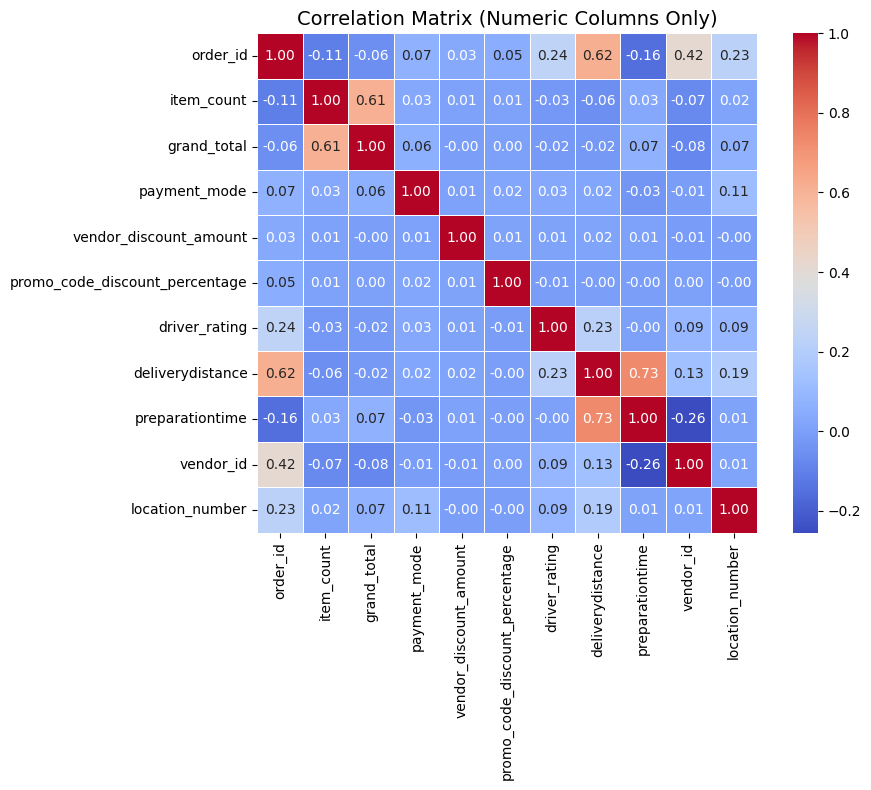

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called `orders`

# 1. Select only numeric columns
numeric_orders = orders.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

# 2. Calculate the correlation matrix
correlation_matrix = numeric_orders.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix (Numeric Columns Only)", fontsize=14)
plt.tight_layout()
plt.show()



In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Performing Feature Engineering

In [86]:
vendors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 59 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    100 non-null    int64  
 1   authentication_id     100 non-null    int64  
 2   latitude              100 non-null    float64
 3   longitude             100 non-null    float64
 4   vendor_category_en    100 non-null    object 
 5   vendor_category_id    100 non-null    int8   
 6   delivery_charge       100 non-null    float16
 7   serving_distance      100 non-null    int8   
 8   is_open               100 non-null    int64  
 9   OpeningTime           91 non-null     object 
 10  OpeningTime2          91 non-null     object 
 11  prepration_time       100 non-null    int8   
 12  commission            85 non-null     float16
 13  is_haked_delivering   100 non-null    object 
 14  discount_percentage   100 non-null    float16
 15  status                10

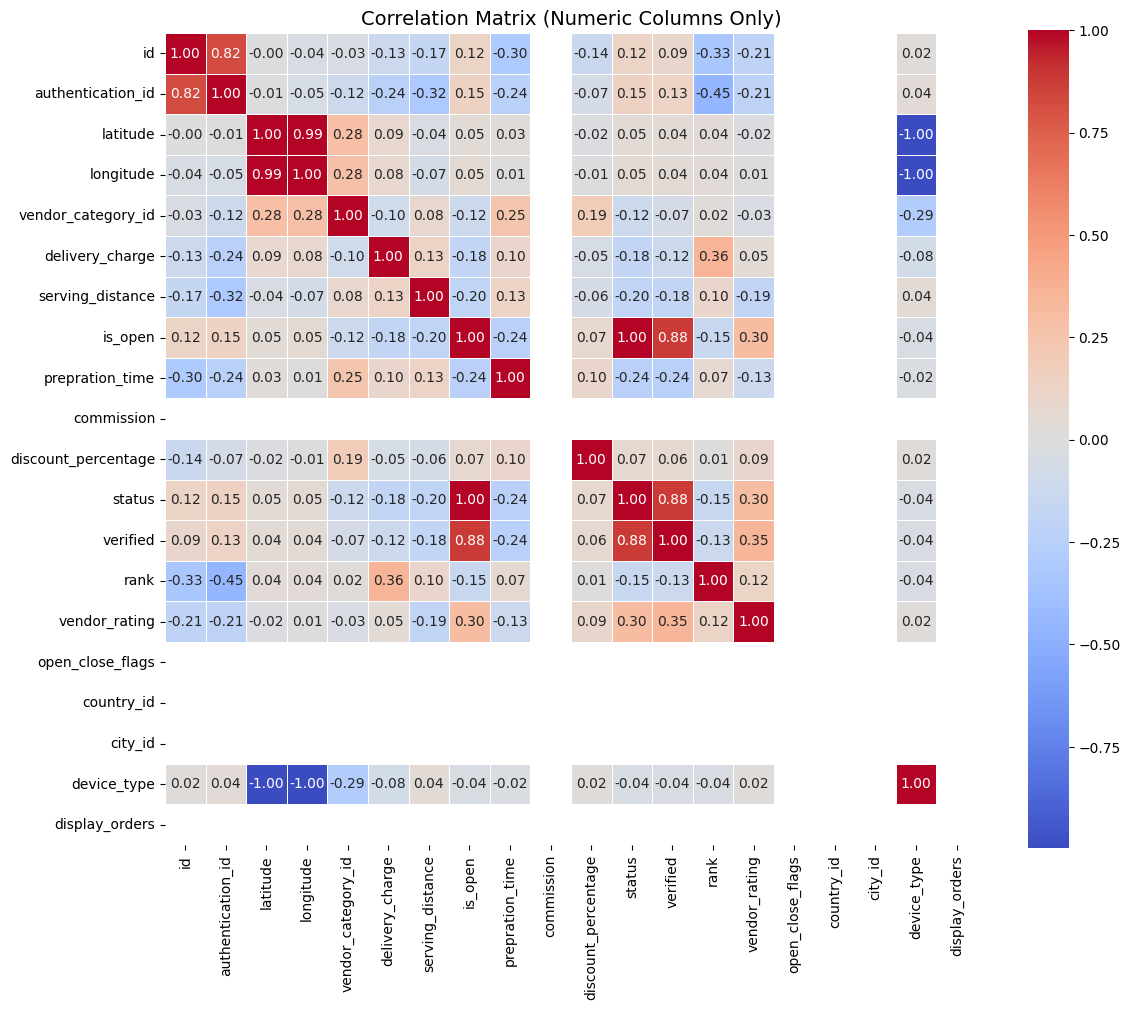

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select only numeric columns
numeric_df = vendors.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

# 2. Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Set the plot size
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)

plt.title("Correlation Matrix (Numeric Columns Only)", fontsize=14)
plt.tight_layout()
plt.show()


Vendors Features 

In [88]:
vendors['vendor_id'] = vendors['id']
vendors['vendor_tag_count'] = vendors['vendor_tag_name'].str.count(',') + 1


In [89]:
vendors_cleaned = vendors[['vendor_id', 'latitude', 'longitude', 'vendor_rating', 'serving_distance', 'prepration_time', 'vendor_tag_count']].rename(columns={'latitude': 'vendor_latitude', 'longitude': 'vendor_longitude'})


Combinig features 

In [90]:
all_customers = pd.concat([train_customers, test_customers], ignore_index=True)
all_customers['dob'] = pd.to_numeric(all_customers['dob'], errors='coerce')

In [91]:
all_customers['age'] = 2025 - all_customers['dob']

In [92]:
all_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44442 entries, 0 to 44441
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  44442 non-null  object 
 1   gender       28841 non-null  object 
 2   dob          3894 non-null   float64
 3   status       44442 non-null  int64  
 4   verified     44442 non-null  int64  
 5   language     27027 non-null  object 
 6   created_at   44442 non-null  object 
 7   updated_at   44442 non-null  object 
 8   age          3894 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 3.1+ MB


There are missing values in `gender`  `language` `dob` `age`

In [93]:
all_customers['age'].fillna(all_customers['age'].median(), inplace=True) # filling dob misisng value uisng median

In [94]:
# Calculate account age
all_customers['created_at'] = pd.to_datetime(all_customers['created_at'], errors='coerce')
all_customers['account_age_days'] = (pd.to_datetime('2025-08-01') - all_customers['created_at']).dt.days

In [95]:
# Label encode gender
all_customers['gender'].fillna('Unknown', inplace=True)
le_gender = LabelEncoder()
all_customers['gender_encoded'] = le_gender.fit_transform(all_customers['gender'])
customers_cleaned = all_customers[['customer_id', 'age', 'account_age_days', 'gender_encoded']]

In [96]:
# combining all the location features from traina nd test data 
all_locations = pd.concat([train_locations, test_locations], ignore_index=True)

Merge Orders table  with Features

to forms our base training dataset with positive examples (actual orders)

In [97]:
train_df = orders.merge(customers_cleaned, on='customer_id', how='left')
train_df = train_df.merge(all_locations, on=['customer_id', 'location_number'], how='left')
train_df = train_df.merge(vendors_cleaned, on='vendor_id', how='left')

In [98]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135502 entries, 0 to 135501
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   order_id                        135432 non-null  float64
 1   customer_id                     135502 non-null  object 
 2   item_count                      128577 non-null  float16
 3   grand_total                     135502 non-null  float32
 4   payment_mode                    135502 non-null  int64  
 5   promo_code                      4325 non-null    object 
 6   vendor_discount_amount          135502 non-null  float16
 7   promo_code_discount_percentage  66040 non-null   float16
 8   is_favorite                     100307 non-null  object 
 9   is_rated                        135502 non-null  object 
 10  driver_rating                   135502 non-null  int64  
 11  deliverydistance                135502 non-null  float64
 12  preparationtime 

In [99]:
train_df.shape

(135502, 35)

In [100]:
# Add a target variable: 1 for all existing orders
train_df['target'] = 1

In [101]:
import gc
import lightgbm as lgb

Negative Sampling 

For a recommendation model to learn, it needs negative examples (i.e., vendors a customer did NOT order from).

In [102]:
all_vendor_ids = vendors['vendor_id'].unique()

In [103]:
# Create a dataframe of all customer-vendor pairs from the orders
customer_vendor_pairs = train_df[['customer_id', 'vendor_id']].drop_duplicates()
# Create a dataframe of all possible customer-vendor combinations
all_combinations = pd.DataFrame(np.array(np.meshgrid(train_df['customer_id'].unique(), all_vendor_ids)).T.reshape(-1, 2), columns=['customer_id', 'vendor_id'])
# Find the combinations that are NOT in the orders (these are our negative samples)
negative_samples = all_combinations.merge(customer_vendor_pairs, on=['customer_id', 'vendor_id'], how='left', indicator=True)
negative_samples = negative_samples[negative_samples['_merge'] == 'left_only']

In [104]:
# We don't need all negative samples. Let's take a random sample to balance the dataset.
# A 3:1 ratio of negative to positive samples is a good starting point.
num_positive_samples = len(train_df)
negative_samples = negative_samples.sample(n=num_positive_samples * 3, random_state=42)
negative_samples['target'] = 0

In [105]:
negative_samples

,customer_id,vendor_id,_merge,target
864590,8M74CQ9,681,left_only,0
863580,ZRSKN4W,537,left_only,0
2017898,1M4M3SP,858,left_only,0
2648366,P60LB7W,295,left_only,0
1385197,YVLYD88,856,left_only,0
...,...,...,...,...
212913,436H5RZ,78,left_only,0
2558316,Z7FF89G,82,left_only,0
2156957,QTS0DVZ,243,left_only,0
338426,VFMS8Z0,110,left_only,0


In [106]:
# Combine positive and negative samples to create the final training set
train_full = pd.concat([train_df, negative_samples], ignore_index=True)

In [107]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542008 entries, 0 to 542007
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   order_id                        135432 non-null  float64 
 1   customer_id                     542008 non-null  object  
 2   item_count                      128577 non-null  float16 
 3   grand_total                     135502 non-null  float32 
 4   payment_mode                    135502 non-null  float64 
 5   promo_code                      4325 non-null    object  
 6   vendor_discount_amount          135502 non-null  float16 
 7   promo_code_discount_percentage  66040 non-null   float16 
 8   is_favorite                     100307 non-null  object  
 9   is_rated                        135502 non-null  object  
 10  driver_rating                   135502 non-null  float64 
 11  deliverydistance                135502 non-null  float64 
 12  pr

In [108]:
train_full.isnull().sum()

order_id                          406576
customer_id                            0
item_count                        413431
grand_total                       406506
payment_mode                      406506
promo_code                        537683
vendor_discount_amount            406506
promo_code_discount_percentage    475968
is_favorite                       441701
is_rated                          406506
driver_rating                     406506
deliverydistance                  406506
preparationtime                   462066
delivery_time                     536876
order_accepted_time               454854
driver_accepted_time              495431
ready_for_pickup_time             457571
picked_up_time                    457952
delivered_time                    456071
delivery_date                     506464
vendor_id                              0
location_number                   406506
CID X LOC_NUM X VENDOR            406506
age                               409782
account_age_days

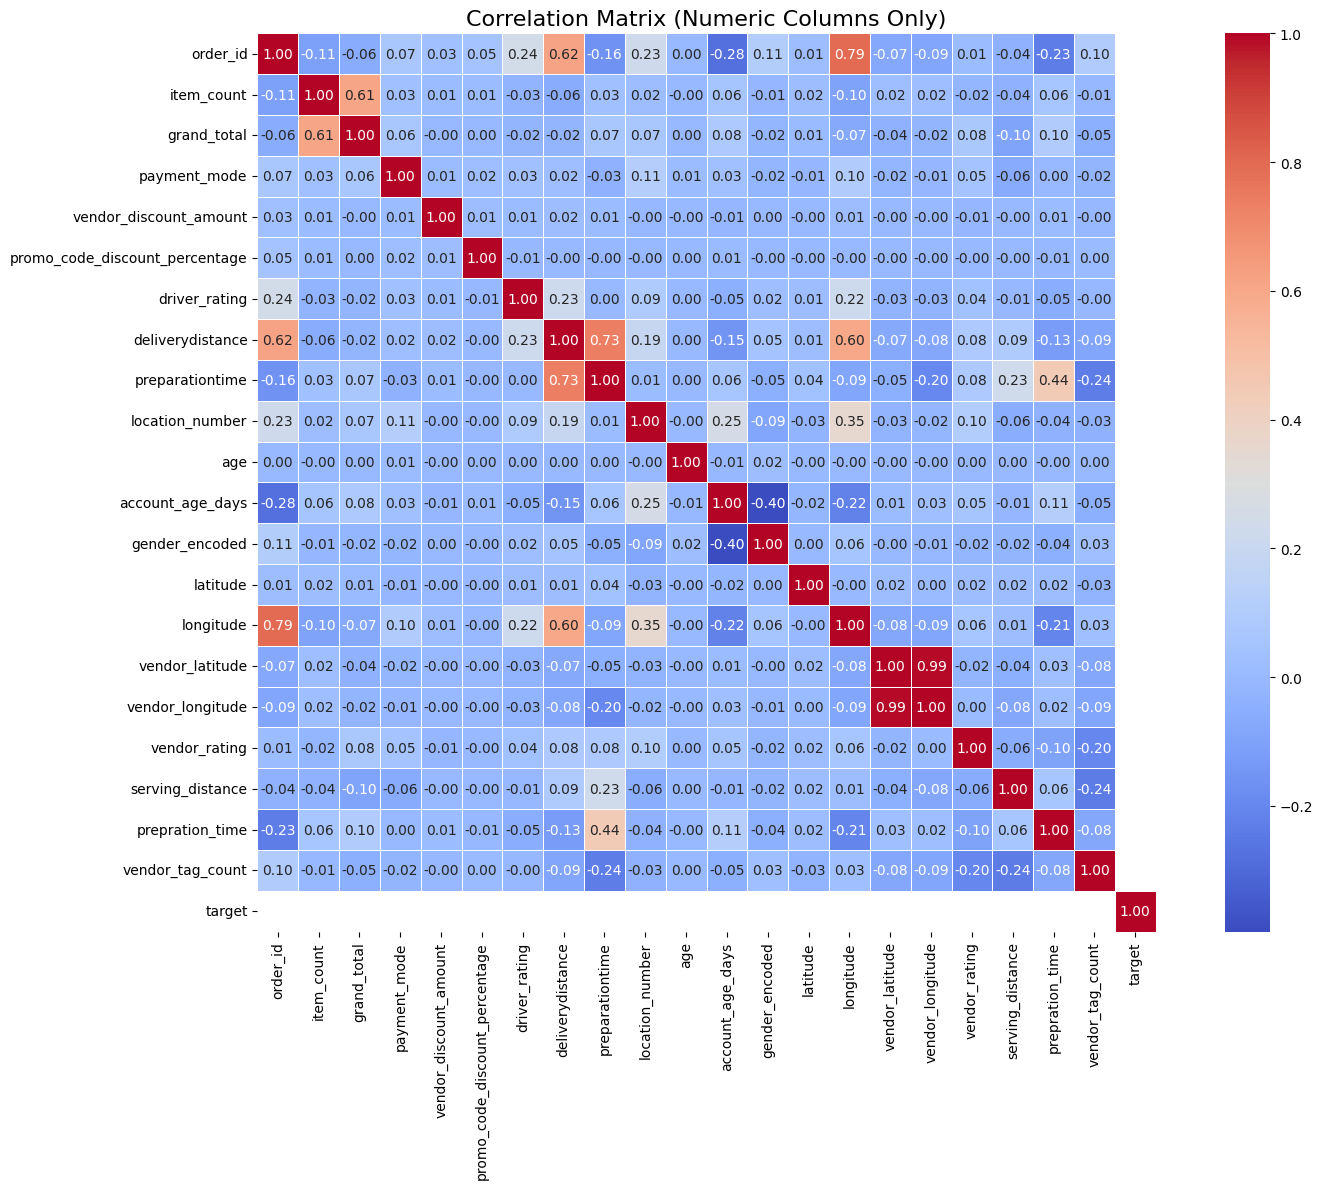

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Select numeric columns only
numeric_df = train_full.select_dtypes(include=['int64', 'float16', 'float32', 'float64'])

# Step 2: Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Step 3: Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix (Numeric Columns Only)", fontsize=16)
plt.tight_layout()
plt.show()


In [110]:
# First, drop the columns that are sparse due to the concat, then merge them back for all rows.
cols_to_drop = ['age', 'account_age_days', 'gender_encoded', 'latitude', 'longitude', 'location_type', 'vendor_latitude', 'vendor_longitude', 'vendor_rating', 'serving_distance', 'prepration_time', 'vendor_tag_count']
train_full = train_full.drop(columns=[col for col in cols_to_drop if col in train_full.columns])

In [111]:
train_full = train_full.merge(customers_cleaned, on='customer_id', how='left')

In [112]:
# For negative samples, we don't have a specific location, so we'll use the customer's first known location (location_number 0)
# First, get the primary location for all customers
primary_locations = all_locations[all_locations['location_number'] == 0]
train_full = train_full.merge(primary_locations.drop(columns='location_number'), on='customer_id', how='left')
train_full = train_full.merge(vendors_cleaned, on='vendor_id', how='left')

In [113]:
# Clean up memory
del orders, train_customers, train_locations, all_combinations, negative_samples, customer_vendor_pairs
gc.collect()

64464

### Finalizing features

In [114]:
# Calculate distance between customer and vendor
# Since lat/lon are masked, we use Euclidean distance which preserves relative proximity
train_full['distance_km'] = np.sqrt((train_full['latitude'] - train_full['vendor_latitude'])**2 + (train_full['longitude'] - train_full['vendor_longitude'])**2)

In [115]:
# Interaction features (e.g., average order value per customer)
# Calculate these on the original orders data to avoid data leakage from the target
customer_agg = train_df.groupby('customer_id')['grand_total'].agg(['mean', 'count']).rename(columns={'mean': 'cust_avg_order_val', 'count': 'cust_order_count'})
vendor_agg = train_df.groupby('vendor_id')['grand_total'].agg(['mean', 'count']).rename(columns={'mean': 'vendor_avg_order_val', 'count': 'vendor_order_count'})


In [116]:
train_full = train_full.merge(customer_agg, on='customer_id', how='left')
train_full = train_full.merge(vendor_agg, on='vendor_id', how='left')

In [117]:
# Fill NaNs that resulted from merges (e.g., customers with no orders in negative samples)
for col in ['cust_avg_order_val', 'cust_order_count', 'vendor_avg_order_val', 'vendor_order_count']:
    train_full[col].fillna(0, inplace=True)

### Preparing data for the model

In [118]:
# Define features and target
features = [
    'age', 'account_age_days', 'gender_encoded',
    'vendor_rating', 'serving_distance', 'prepration_time', 'vendor_tag_count',
    'distance_km',
    'cust_avg_order_val', 'cust_order_count',
    'vendor_avg_order_val', 'vendor_order_count'
]
target = 'target'

In [119]:
# Final training data
X = train_full[features].astype('float32')
y = train_full[target].astype('int8')

For base line we are going to use `regression model` 

In [120]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [121]:
from sklearn.ensemble import RandomForestClassifier

In [122]:
# Instantiate a RandomForestClassifier
# n_jobs=-1 uses all available CPU cores, random_state=42 ensures reproducibility
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [123]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [136]:
# --- 8. Model Evaluation ---
print("Step 8/9: Evaluating baseline model performance...")
y_pred_proba = rf_model.predict_proba(X_val)[:, 1]
y_pred_binary = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
auc_score = roc_auc_score(y_val, y_pred_proba)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)

print("\n--- RandomForest Baseline Performance ---")
print(f"AUC Score: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Step 8/9: Evaluating baseline model performance...

--- RandomForest Baseline Performance ---
AUC Score: 0.8847
Precision: 0.7759
Recall:    0.5301
F1-Score:  0.6299


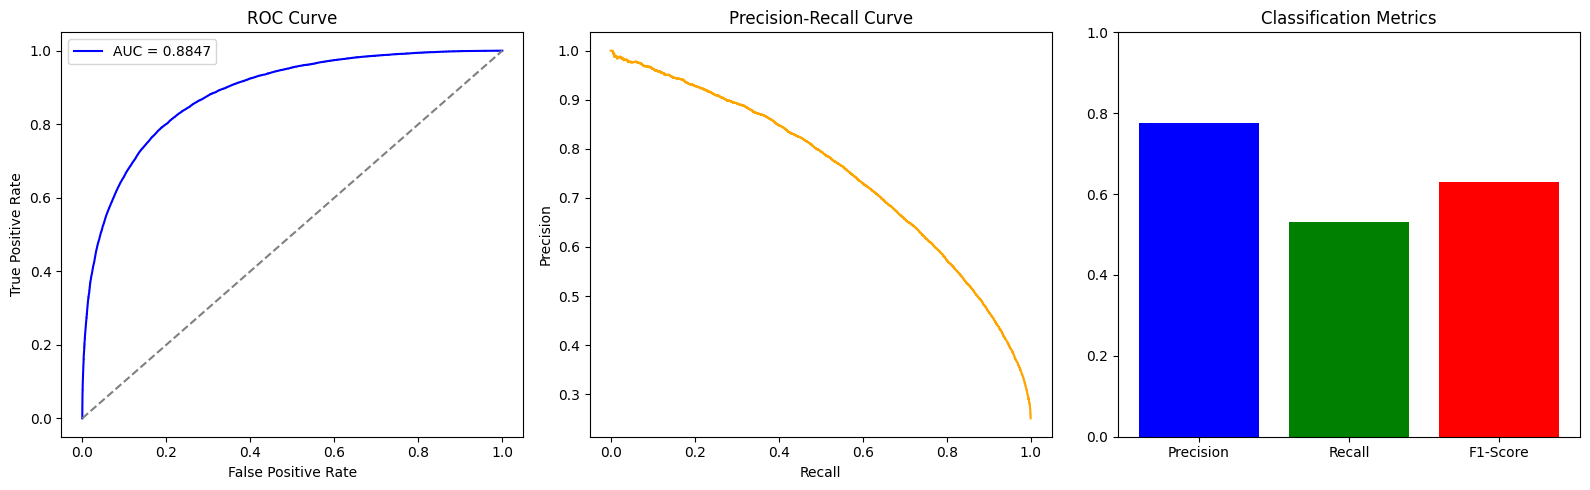

In [137]:
import matplotlib.pyplot as plt
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_pred_proba)

# Plotting
plt.figure(figsize=(16, 5))

# ROC Curve plot
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Precision-Recall Curve plot
plt.subplot(1, 3, 2)
plt.plot(recall_vals, precision_vals, color='orange')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Bar chart for Precision, Recall, F1-Score
plt.subplot(1, 3, 3)
metrics = [precision, recall, f1]
names = ['Precision', 'Recall', 'F1-Score']
colors = ['blue', 'green', 'red']
plt.bar(names, metrics, color=colors)
plt.ylim(0, 1)
plt.title('Classification Metrics')

plt.tight_layout()
plt.show()


--- RandomForest Baseline Performance ---

` AUC Score `: 0.8847

` Precision `: 0.7759

` Recall `:    0.5301

` F1-Score `:  0.6299

## Using LGBM

In [125]:
# LightGBM model parameters
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
}

In [126]:
model = lgb.LGBMClassifier(**lgb_params)

In [127]:
# Train the model with early stopping
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric='auc',
          callbacks=[lgb.early_stopping(100, verbose=False)])

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [138]:
# Predict probabilities on validation set using the trained LightGBM model
y_pred_proba = model.predict_proba(X_val)[:, 1]  # probabilities for positive class

# Convert probabilities to binary predictions with threshold 0.5
y_pred_binary = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

auc_score = roc_auc_score(y_val, y_pred_proba)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)

print("\n--- LightGBM Model Performance ---")
print(f"AUC Score: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")



--- LightGBM Model Performance ---
AUC Score: 0.9088
Precision: 0.7746
Recall:    0.6307
F1-Score:  0.6952


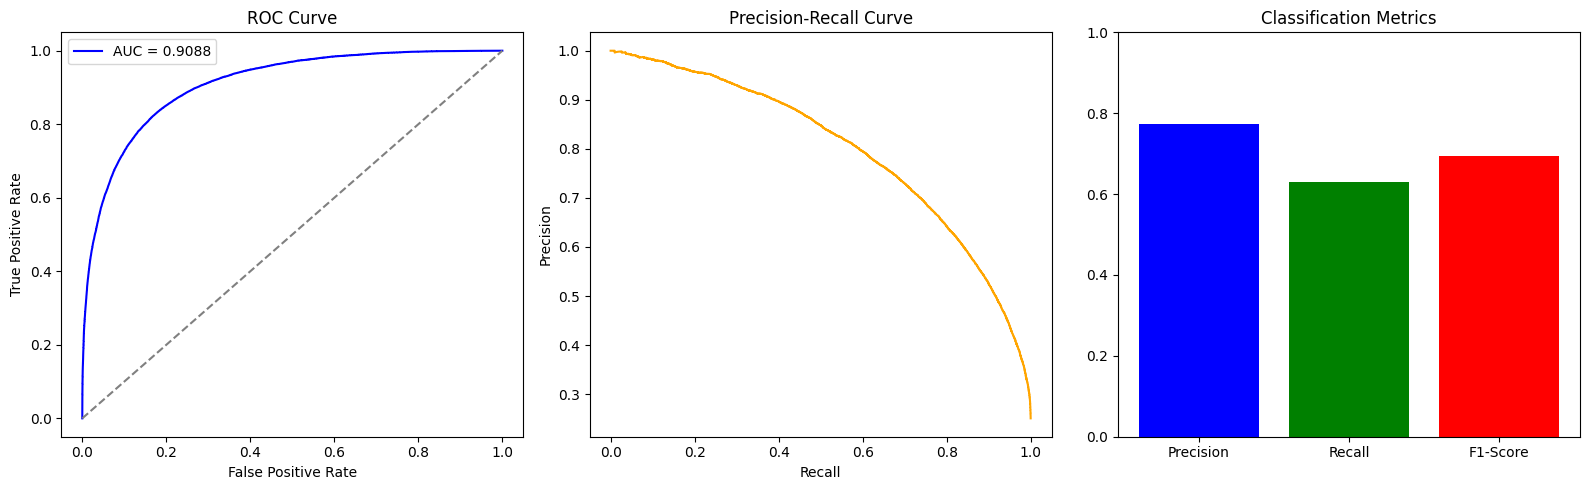

In [139]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_pred_proba)

# Plotting
plt.figure(figsize=(16, 5))

# ROC Curve plot
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Precision-Recall Curve plot
plt.subplot(1, 3, 2)
plt.plot(recall_vals, precision_vals, color='orange')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Bar chart for Precision, Recall, F1-Score
plt.subplot(1, 3, 3)
metrics = [precision, recall, f1]
names = ['Precision', 'Recall', 'F1-Score']
colors = ['blue', 'green', 'red']
plt.bar(names, metrics, color=colors)
plt.ylim(0, 1)
plt.title('Classification Metrics')

plt.tight_layout()
plt.show()


--- LightGBM Model Performance ---

`AUC Score`: 0.9088

`Precision`: 0.7746

`Recall`:    0.6307

`F1-Score`:  0.6952

# Since lgm has more accuracy then rf we are going with lgm 

In [140]:
# Clean up memory
del X, y, X_train, X_val, y_train, y_val, train_full
gc.collect()

33665

Prediction and Submission File Generation

In [141]:

# Create the test set by crossing test customers/locations with all vendors
test_customers_locations = test_customers.merge(test_locations, on='customer_id')
test_df_base = pd.DataFrame(np.array(np.meshgrid(test_customers_locations['customer_id'].unique(), all_vendor_ids)).T.reshape(-1, 2), columns=['customer_id', 'vendor_id'])
test_df = test_customers_locations.merge(test_df_base, on='customer_id', how='left')

# Merge all the features we created for the training set
test_df = test_df.merge(customers_cleaned, on='customer_id', how='left')
test_df = test_df.merge(vendors_cleaned, on='vendor_id', how='left')
test_df['distance_km'] = np.sqrt((test_df['latitude'] - test_df['vendor_latitude'])**2 + (test_df['longitude'] - test_df['vendor_longitude'])**2)
test_df = test_df.merge(customer_agg, on='customer_id', how='left')
test_df = test_df.merge(vendor_agg, on='vendor_id', how='left')


In [142]:
# Fill NaNs for new customers/vendors
for col in ['cust_avg_order_val', 'cust_order_count', 'vendor_avg_order_val', 'vendor_order_count']:
    test_df[col].fillna(0, inplace=True)

In [143]:
# Ensure all feature columns are present and in the correct order
X_test = test_df[features].astype('float32')

In [144]:
# Predict probabilities
predictions = model.predict_proba(X_test)[:, 1]

In [145]:
# Create the submission file
submission_df = test_df[['customer_id', 'location_number', 'vendor_id']].copy()
submission_df['target'] = predictions

In [ ]:
# Format the ID column as required: 'CID X LOC_NUM X VENDOR'
submission_df['CID X LOC_NUM X VENDOR'] = submission_df['customer_id'].astype(str) + ' X ' + submission_df['location_number'].astype(str) + ' X ' + submission_df['vendor_id'].astype(str)

# Final submission file
final_submission = submission_df[['CID X LOC_NUM X VENDOR', 'target']]
final_submission.to_csv('LGBM_submission1.csv', index=False)
